In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanicset1/Titanic-Dataset.csv


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Load Titanic dataset
titanic = pd.read_csv('/kaggle/input/titanicset1/Titanic-Dataset.csv')
print (titanic.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [4]:
# Preprocessing: Handle Missing Values and Encode Categorical Data
titanic['Age'] = titanic['Age'].fillna(titanic['Age'].median())
titanic['Embarked'] = titanic['Embarked'].fillna(titanic['Embarked'].mode()[0])
titanic['Fare'] = titanic['Fare'].fillna(titanic['Fare'].median())
titanic['Sex'] = titanic['Sex'].map({'male': 0, 'female': 1})
titanic['Embarked'] = titanic['Embarked'].astype('category').cat.codes



In [5]:
# Data Distribution: Explore and Visualize
print("Dataset Overview:")
print(titanic.describe())  # Summary statistics

Dataset Overview:
       PassengerId    Survived      Pclass         Sex         Age  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642    0.352413   29.361582   
std     257.353842    0.486592    0.836071    0.477990   13.019697   
min       1.000000    0.000000    1.000000    0.000000    0.420000   
25%     223.500000    0.000000    2.000000    0.000000   22.000000   
50%     446.000000    0.000000    3.000000    0.000000   28.000000   
75%     668.500000    1.000000    3.000000    1.000000   35.000000   
max     891.000000    1.000000    3.000000    1.000000   80.000000   

            SibSp       Parch        Fare    Embarked  
count  891.000000  891.000000  891.000000  891.000000  
mean     0.523008    0.381594   32.204208    1.536476  
std      1.102743    0.806057   49.693429    0.791503  
min      0.000000    0.000000    0.000000    0.000000  
25%      0.000000    0.000000    7.910400    1.000000  
50%      0.0000

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


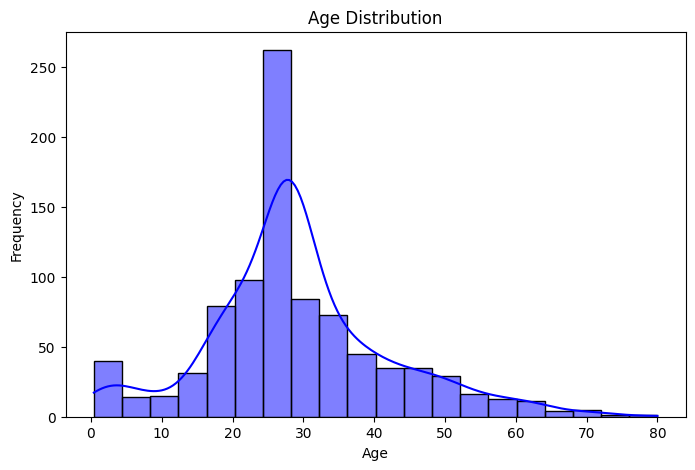

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Plot Age Distribution
plt.figure(figsize=(8, 5))
sns.histplot(titanic['Age'], kde=True, bins=20, color='blue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


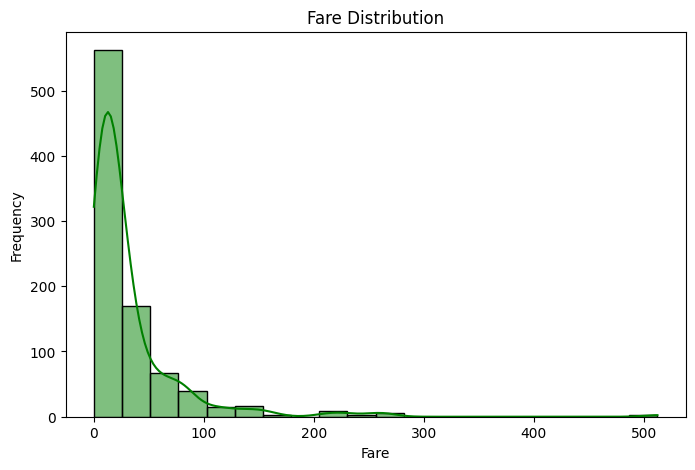

In [7]:
# Plot Fare Distribution
plt.figure(figsize=(8, 5))
sns.histplot(titanic['Fare'], kde=True, bins=20, color='green')
plt.title('Fare Distribution')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.show()

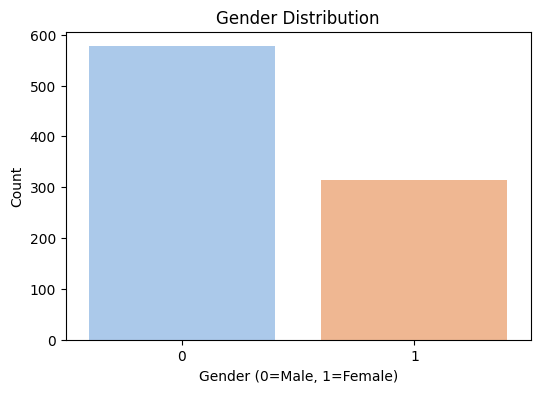

In [8]:
# Count Plot of Sex
plt.figure(figsize=(6, 4))
sns.countplot(data=titanic, x='Sex', palette='pastel')
plt.title('Gender Distribution')
plt.xlabel('Gender (0=Male, 1=Female)')
plt.ylabel('Count')
plt.show()

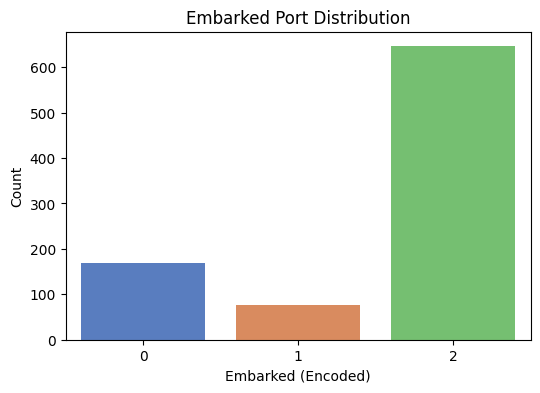

In [9]:
# Count Plot of Embarked Locations
plt.figure(figsize=(6, 4))
sns.countplot(data=titanic, x='Embarked', palette='muted')
plt.title('Embarked Port Distribution')
plt.xlabel('Embarked (Encoded)')
plt.ylabel('Count')
plt.show()

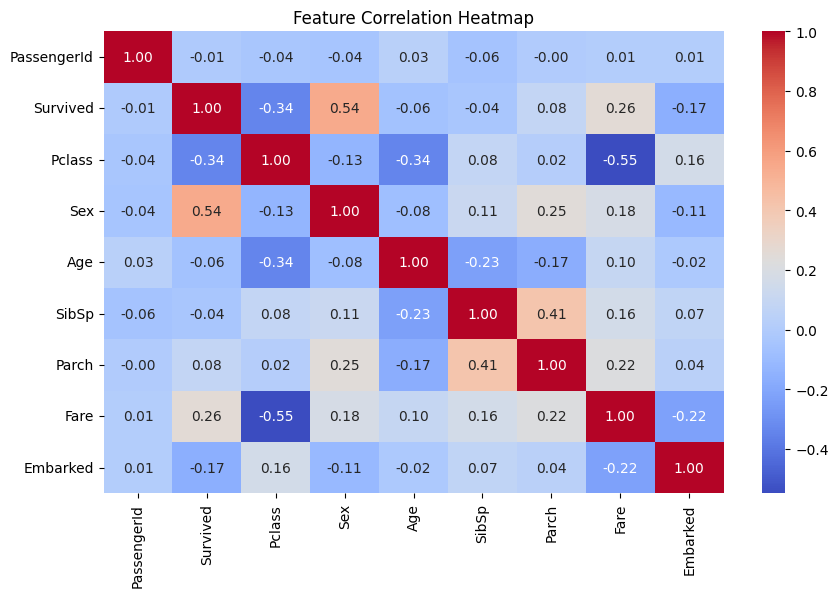

In [10]:
# Select only numeric columns for the correlation matrix
numeric_columns = titanic.select_dtypes(include=['number'])
correlation_matrix = numeric_columns.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()


In [11]:
# Feature Engineering
titanic['Familysize'] = titanic['SibSp'] + titanic['Parch'] + 1
titanic['Isalone'] = (titanic['Familysize'] == 1).astype(int)
titanic['HasCabin'] = titanic['Cabin'].notnull().astype(int)
titanic['Title'] = titanic['Name'].str.extract(' ([A-Za-z]+)\.', expand=False).map(
    {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4}
).fillna(4)
titanic['Pclass_Fare'] = titanic['Pclass'] * titanic['Fare']
titanic['Age_Fare'] = titanic['Age'] * titanic['Fare']

In [12]:
# Define Features and Target Variables
X = titanic[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Familysize', 'Isalone', 'HasCabin', 'Title', 'Pclass_Fare', 'Age_Fare']]
y = titanic['Survived']

In [13]:
# Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [14]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [15]:
# Random Forest with Hyperparameter Tuning
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions, n_iter=10, cv=3, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_depth': [10, 20, 30],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='accuracy')

In [16]:
# Evaluate the Best Random Forest Model
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)


In [17]:
# Metrics and Evaluation
rf_accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)


In [18]:
# Print Results
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Random Forest Accuracy: 0.90
Confusion Matrix:
[[ 93  10]
 [ 11 106]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       103
           1       0.91      0.91      0.91       117

    accuracy                           0.90       220
   macro avg       0.90      0.90      0.90       220
weighted avg       0.90      0.90      0.90       220



In [19]:
# Save the final processed Titanic dataset to a CSV file
finalized_dataset_path = "finalized_titanic_dataset.csv"
titanic.to_csv(finalized_dataset_path, index=False)

# Print confirmation
print(f"Finalized dataset saved as: {finalized_dataset_path}")

# Output the finalized dataset (to view in the console)
print(titanic.head())


Finalized dataset saved as: finalized_titanic_dataset.csv
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    0  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.0      1      0   
2                             Heikkinen, Miss. Laina    1  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.0      1      0   
4                           Allen, Mr. William Henry    0  35.0      0      0   

             Ticket     Fare Cabin  Embarked  Familysize  Isalone  HasCabin  \
0         A/5 21171   7.2500   NaN         2           2        0         0   
1          PC 17599  71.2833   C85         0           2        0         1   
2